In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
from tqdm import tqdm
import time as tim

In [16]:
# initialize constants (SI units)
c = 2.99792458e8  # speed of light
m_e = 9.10938356e-31
q_e = 1.60217662e-19
e_0 = 8.85418782e-12
# set pure spectral properties
lambda_0 = 800e-9  # central wavelength
tau_0 = 10e-15  # FL pulse duration 1/e2 intensity half-width (same def as beam waist)
# calculate frequency properties
omega_0 = 2*np.pi*c/lambda_0
delta_omega = 2/tau_0
# set initial beam waist
w_0 = 4e-6
# calculate Rayleigh range
z_R = (np.pi*w_0**2)/(lambda_0)
# beam power
P = 100e12
# chirp
GDD_0 = 0  # Group Delay Dispersion fs^2
GDD = GDD_0*(1e-15)**2
# CEP
Psi_0 = np.pi
# intial electron velocity
z_0 = 0.5*z_R
beta_0 = 0.0

0.5572593212127686 seconds
26676.18165728283 eV


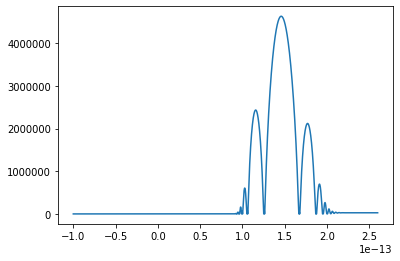

In [17]:
# amplitude factor
Amp = np.sqrt(8*P/(np.pi*e_0*c))
# stretched pulse duration
tau = np.sqrt(tau_0**2 + (2*GDD/tau_0)**2)

t_start = -10*tau_0
t_end = +1e5*tau_0
n = np.round(np.sqrt(P*tau_0/(tau*w_0**2))/(5e10))  # empirically chosen resolution based on field strength
num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))
time = np.linspace(t_start, t_end, num_t)
dt = time[1]-time[0]

z = np.empty(shape=(len(time)))
beta = np.empty(shape=(len(time)))
deriv2 = np.empty(shape=(len(time)))
KE = np.zeros(shape=(len(time)))

beta[0] = beta_0
z[0] = beta[0]*c*time[0]+z_0

start_time = tim.time()
#do 5th order Adams-Bashforth finite difference method
for k in range(0, len(time)-1):

    field_temp = np.cos(Psi_0+2*np.arctan(z[k]/z_R)+omega_0*time[k]-omega_0*z[k]/c)/(z_R*(1+(z[k]/z_R)**2))
    env_temp = np.exp(-((time[k]-z[k]/c)/tau)**2)
    temp_phase = np.exp(1j*(2*GDD/(tau_0**4+(2*GDD)**2))*(time[k]-z[k]/c)**2)
    field_total = Amp*(tau_0/tau)*field_temp*env_temp*temp_phase
    deriv2[k] = (-q_e*np.real(field_total)*((1-beta[k]**2)**(3/2))/(m_e*c))

    if k==0:
        z[k+1] = z[k] + dt*c*beta[k]
        beta[k+1] = beta[k] + dt*deriv2[k]
    elif k==1:
        z[k+1] = z[k] + dt*c*(1.5*beta[k]-0.5*beta[k-1])
        beta[k+1] = beta[k] + dt*(1.5*deriv2[k]-0.5*deriv2[k-1])
    elif k==2:
        z[k+1] = z[k] + dt*c*((23/12)*beta[k]-(4/3)*beta[k-1]+(5/12)*beta[k-2])
        beta[k+1] = beta[k] + dt*((23/12)*deriv2[k]-(4/3)*deriv2[k-1]+(5/12)*deriv2[k-2])
    elif k==3:
        z[k+1] = z[k] + dt*c*((55/24)*beta[k]-(59/24)*beta[k-1]+(37/24)*beta[k-2]-(3/8)*beta[k-3])
        beta[k+1] = beta[k] + dt*((55/24)*deriv2[k]-(59/24)*deriv2[k-1]+(37/24)*deriv2[k-2]-(3/8)*deriv2[k-3])
    else:
        z[k+1] = z[k] + dt*c*((1901/720)*beta[k]-(1387/360)*beta[k-1]+(109/30)*beta[k-2]-(637/360)*beta[k-3]+(251/720)*beta[k-4])
        beta[k+1] = beta[k] + dt*((1901/720)*deriv2[k]-(1387/360)*deriv2[k-1]+(109/30)*deriv2[k-2]-(637/360)*deriv2[k-3]+(251/720)*deriv2[k-4])
        
    KE[k+1] = ((1/np.sqrt(1-beta[k+1]**2))-1)*m_e*c**2/q_e
    
    if (time[k] > 10*tau_0 and np.mean(np.abs(np.diff(KE[k-np.int(4*n):k+1])))/(KE[k+1]*dt) < 1e7):
        k_stop = k+1
        break

end_time = tim.time()
print(str(end_time-start_time)+' seconds')
print(str(KE[k_stop])+' eV')

plt.plot(time[:k_stop], KE[:k_stop])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(-100000000.0, 100000000.0)

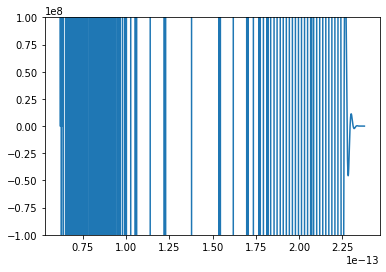

In [9]:
plt.plot(time[1:], np.diff(KE)/(KE[1:]*dt))
#plt.xlim(0, 1.1e-11)
plt.ylim(-1e8, 1e8)

In [5]:
k = 100000
start_time = tim.time()
np.mean(np.abs(np.diff(KE[k-np.int(4*n):k+1]))/(KE[k+1]*dt))
end_time = tim.time()
print(end_time-start_time)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.0010149478912353516


In [6]:
np.mean(np.abs(np.diff(KE[k-np.int(4*n):k+1]))/(KE[k+1]*dt))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


nan